In [1]:
# general
import math
import numpy as np
import pickle

# visualisation
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pylab as plt
from autoprot import preprocessing as pp
from autoprot import visualization as vis

Checking R installation...
Loading required package: pak
Warning message:
package 'pak' was built under R version 4.2.3
ℹ Loading metadata database
✔ Loading metadata database ... done
ℹ No downloads are needed
✔ 1 pkg + 183 deps: kept 61 [11.5s]
Loading required package: github::kreutz-lab/DIMAR
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required pack

In [2]:
TXT_FOLDER = "data/txt_demo"
#TXT_FOLDER = "data/txt"

pg = pp.read_csv(f"{TXT_FOLDER}/proteinGroups.txt")

# remove Decoy, identified by site and contaminants
pg = pp.cleaning(pg)

# Removes entries without any quantitative data
pg = pp.remove_non_quant(pg, pg.filter(regex="iBAQ").columns)

# Filters for minimal Sequence coverage of 10%%
pg = pp.filter_seq_cov(pg, 10)

# log transform iBAQs
pg = pp.log(pg, pg.filter(regex="iBAQ").columns, base=10)

pg.head()

122 rows before filter operation.
115 rows after filter operation.
115 rows before filter operation.
115 rows after filter operation.
115 rows before filter operation.
80 rows after filter operation.


,Unnamed: 0,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,...,log10_iBAQ WT_S1_R3_10,log10_iBAQ WT_S1_R3_11,log10_iBAQ WT_S1_R3_2,log10_iBAQ WT_S1_R3_3,log10_iBAQ WT_S1_R3_4,log10_iBAQ WT_S1_R3_5,log10_iBAQ WT_S1_R3_6,log10_iBAQ WT_S1_R3_7,log10_iBAQ WT_S1_R3_8,log10_iBAQ WT_S1_R3_9
1,655,P28795,P28795,12,12,12,Peroxisomal biogenesis factor 3,PEX3,sp|P28795|PEX3_YEAST Peroxisomal biogenesis fa...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,661,P29340,P29340,3,3,3,Ubiquitin-conjugating enzyme E2-21 kDa,PEX4,sp|P29340|UBCX_YEAST Ubiquitin-conjugating enz...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,804,P32800;P32800-2,P32800;P32800-2,9;8,9;8,9;8,Peroxisomal biogenesis factor 2,PEX2,sp|P32800|PEX2_YEAST Peroxisomal biogenesis fa...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,860,P33760,P33760,11,11,11,Peroxisomal ATPase PEX6,PEX6,sp|P33760|PEX6_YEAST Peroxisomal ATPase PEX6 O...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,896,P35056,P35056,25,25,25,Peroxisomal targeting signal receptor,PEX5,sp|P35056|PEX5_YEAST Peroxisomal targeting sig...,1,...,NaN,NaN,NaN,4.081383,NaN,NaN,NaN,NaN,NaN,NaN


## Define column pairs for comparison

In [3]:
### Soluble Fractions S1
# SC38 (WT) vs SC377 (TPA 1-3)
AP_cyto_cols = [
    [f"log10_iBAQ WT_S1_R{rep}_{gel_slice}", f"log10_iBAQ TPA_S1_R{rep}_{gel_slice}"]
    for gel_slice in np.arange(1, 12)
    for rep in np.arange(1, 4)
]

AP_cyto_cols

[['log10_iBAQ WT_S1_R1_1', 'log10_iBAQ TPA_S1_R1_1'],
 ['log10_iBAQ WT_S1_R2_1', 'log10_iBAQ TPA_S1_R2_1'],
 ['log10_iBAQ WT_S1_R3_1', 'log10_iBAQ TPA_S1_R3_1'],
 ['log10_iBAQ WT_S1_R1_2', 'log10_iBAQ TPA_S1_R1_2'],
 ['log10_iBAQ WT_S1_R2_2', 'log10_iBAQ TPA_S1_R2_2'],
 ['log10_iBAQ WT_S1_R3_2', 'log10_iBAQ TPA_S1_R3_2'],
 ['log10_iBAQ WT_S1_R1_3', 'log10_iBAQ TPA_S1_R1_3'],
 ['log10_iBAQ WT_S1_R2_3', 'log10_iBAQ TPA_S1_R2_3'],
 ['log10_iBAQ WT_S1_R3_3', 'log10_iBAQ TPA_S1_R3_3'],
 ['log10_iBAQ WT_S1_R1_4', 'log10_iBAQ TPA_S1_R1_4'],
 ['log10_iBAQ WT_S1_R2_4', 'log10_iBAQ TPA_S1_R2_4'],
 ['log10_iBAQ WT_S1_R3_4', 'log10_iBAQ TPA_S1_R3_4'],
 ['log10_iBAQ WT_S1_R1_5', 'log10_iBAQ TPA_S1_R1_5'],
 ['log10_iBAQ WT_S1_R2_5', 'log10_iBAQ TPA_S1_R2_5'],
 ['log10_iBAQ WT_S1_R3_5', 'log10_iBAQ TPA_S1_R3_5'],
 ['log10_iBAQ WT_S1_R1_6', 'log10_iBAQ TPA_S1_R1_6'],
 ['log10_iBAQ WT_S1_R2_6', 'log10_iBAQ TPA_S1_R2_6'],
 ['log10_iBAQ WT_S1_R3_6', 'log10_iBAQ TPA_S1_R3_6'],
 ['log10_iBAQ WT_S1_R1_7', '

## Median Normalisation

Calculate the differences in median between pairs of slices and normalise by the factors.

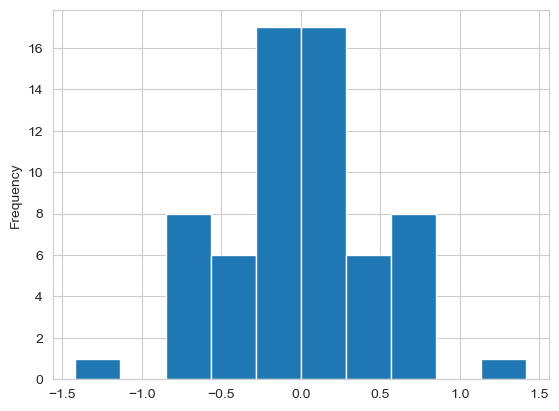

In [4]:
median_iBAQ_srs = pg.filter(
    regex="log10_iBAQ TPA_S1_R[1-3]|log10_iBAQ WT_S1_R[1-3]"
).median(axis=0)

for pair in AP_cyto_cols:
    # get the two median values
    v1, v2 = median_iBAQ_srs[pair]
    # calculate the mean of the medians
    mean_median = np.mean((v1, v2))
    # calculate the difference between each median and the mean (should be symmetric)
    median_iBAQ_srs[pair[0]] = v1 - mean_median
    median_iBAQ_srs[pair[1]] = v2 - mean_median

# check that differences are small and symmetric
median_iBAQ_srs.plot(kind="hist")
plt.savefig("plots/01a_median_histplot.png")
plt.show()

In [5]:
uncorrected_cols = pg.filter(
    regex="log10_iBAQ TPA_S1_R[1-3]|log10_iBAQ WT_S1_R[1-3]"
).columns
corrected_cols = [x + "_median_corrected" for x in uncorrected_cols]

pg[corrected_cols] = pg[uncorrected_cols].subtract(median_iBAQ_srs, axis=1)

pg[corrected_cols]

,log10_iBAQ TPA_S1_R1_1_median_corrected,log10_iBAQ TPA_S1_R1_10_median_corrected,log10_iBAQ TPA_S1_R1_11_median_corrected,log10_iBAQ TPA_S1_R1_2_median_corrected,log10_iBAQ TPA_S1_R1_3_median_corrected,log10_iBAQ TPA_S1_R1_4_median_corrected,log10_iBAQ TPA_S1_R1_5_median_corrected,log10_iBAQ TPA_S1_R1_6_median_corrected,log10_iBAQ TPA_S1_R1_7_median_corrected,log10_iBAQ TPA_S1_R1_8_median_corrected,...,log10_iBAQ WT_S1_R3_10_median_corrected,log10_iBAQ WT_S1_R3_11_median_corrected,log10_iBAQ WT_S1_R3_2_median_corrected,log10_iBAQ WT_S1_R3_3_median_corrected,log10_iBAQ WT_S1_R3_4_median_corrected,log10_iBAQ WT_S1_R3_5_median_corrected,log10_iBAQ WT_S1_R3_6_median_corrected,log10_iBAQ WT_S1_R3_7_median_corrected,log10_iBAQ WT_S1_R3_8_median_corrected,log10_iBAQ WT_S1_R3_9_median_corrected
1,NaN,6.073846,5.859736,5.332955,NaN,5.445817,5.735587,6.734408,7.022909,6.024220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.906645,NaN,NaN,6.511303,NaN,NaN,NaN,NaN,NaN,6.048863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,4.898235,6.033111,6.979855,6.698418,NaN,NaN,4.982363,6.257924,6.228246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,5.177342,7.080829,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.941535,5.343254,5.352922,4.989881,5.482216,NaN,5.416944,5.779840,6.453865,...,NaN,NaN,NaN,4.679768,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,NaN,NaN,5.807785,5.400987,NaN,NaN,NaN,4.952563,4.467578,4.770021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.359789
116,5.765227,6.318843,6.216097,6.517720,6.881259,7.315053,7.347298,6.880186,6.843628,6.602478,...,NaN,NaN,NaN,5.057596,NaN,NaN,NaN,NaN,NaN,6.505113
117,NaN,4.961654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.361979,NaN,6.106687,...,NaN,NaN,5.014384,NaN,NaN,NaN,NaN,4.806183,NaN,NaN


4023 missing values before and 4053 after correction


UnboundLocalError: local variable 'boxprops' referenced before assignment

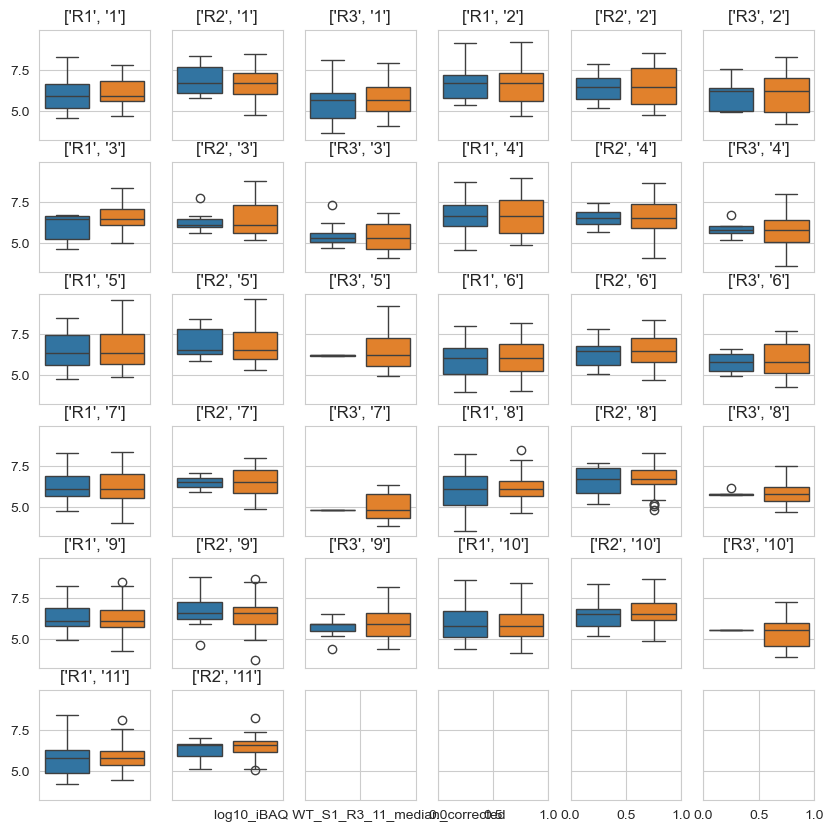

In [6]:
# check that no missing values have been introduced
print(
    f"{pg[uncorrected_cols].isna().sum().sum()} missing values before and {pg[corrected_cols].isna().sum().sum()} after correction"
)

pairs = AP_cyto_cols

# The UnboundLocalError is due to the fact that too few datapoints are present in the demo data
fig, axs = plt.subplots(math.ceil(len(pairs) / 6), 6, figsize=(10, 10), sharey="all")
for pair, ax in zip(pairs, axs.flatten()):
    pair = [x + "_median_corrected" for x in pair]
    sns.boxplot(data=pg[pair], ax=ax)
    
    ax.get_xaxis().set_visible(False)
    ax.set_title(pair[0].split(" ")[-1].split("_")[2:-2])

plt.tight_layout()
plt.savefig("plots/01a_median_boxplot_AP_cyto_cols_slices.png")
plt.show()

In [7]:
# extract the lane names from the experiment names
lanes = list(
    set(
        [
            "_".join(x.split(" ")[1].split("_")[:-3])
            for x in pg.filter(regex="log10_iBAQ.*median_corrected").columns
        ]
    )
)

# calculate non-log value for every group of slices and sum
for l in lanes:
    pg["sum_iBAQ " + l + "_median_corrected"] = (
        pg.filter(regex=f"log10_iBAQ {l}_\d+_median_corrected")
        .apply(lambda x: 10**x)
        .sum(axis=1)
        .replace(0, np.nan)
    )

# check that no missing values have been introduced
print(
    "{} missing values before and {} after summation".format(
        pg.filter(regex="log10_iBAQ.*median_corrected").isna().sum().sum(),
        pg.filter(regex=f"sum_iBAQ .*_S\d+_R\d+_median_corrected").isna().sum().sum(),
    )
)

4053 missing values before and 111 after summation


In [8]:
display(pg.filter(regex="log10_iBAQ.*_corrected").isna().sum(0).sort_values().head())

display(
    pg.filter(regex=f"sum_iBAQ .*_S\d+_R\d+_\w+_corrected").isna().sum(0).sort_values()
)

log10_iBAQ TPA_S1_R1_8_median_corrected    40
log10_iBAQ TPA_S1_R1_7_median_corrected    44
log10_iBAQ WT_S1_R1_1_median_corrected     45
log10_iBAQ TPA_S1_R1_9_median_corrected    46
log10_iBAQ TPA_S1_R3_8_median_corrected    48
dtype: int64

sum_iBAQ TPA_S1_R3_median_corrected     7
sum_iBAQ TPA_S1_R1_median_corrected     8
sum_iBAQ TPA_S1_R2_median_corrected     9
sum_iBAQ WT_S1_R1_median_corrected     12
sum_iBAQ WT_S1_R2_median_corrected     32
sum_iBAQ WT_S1_R3_median_corrected     43
dtype: int64

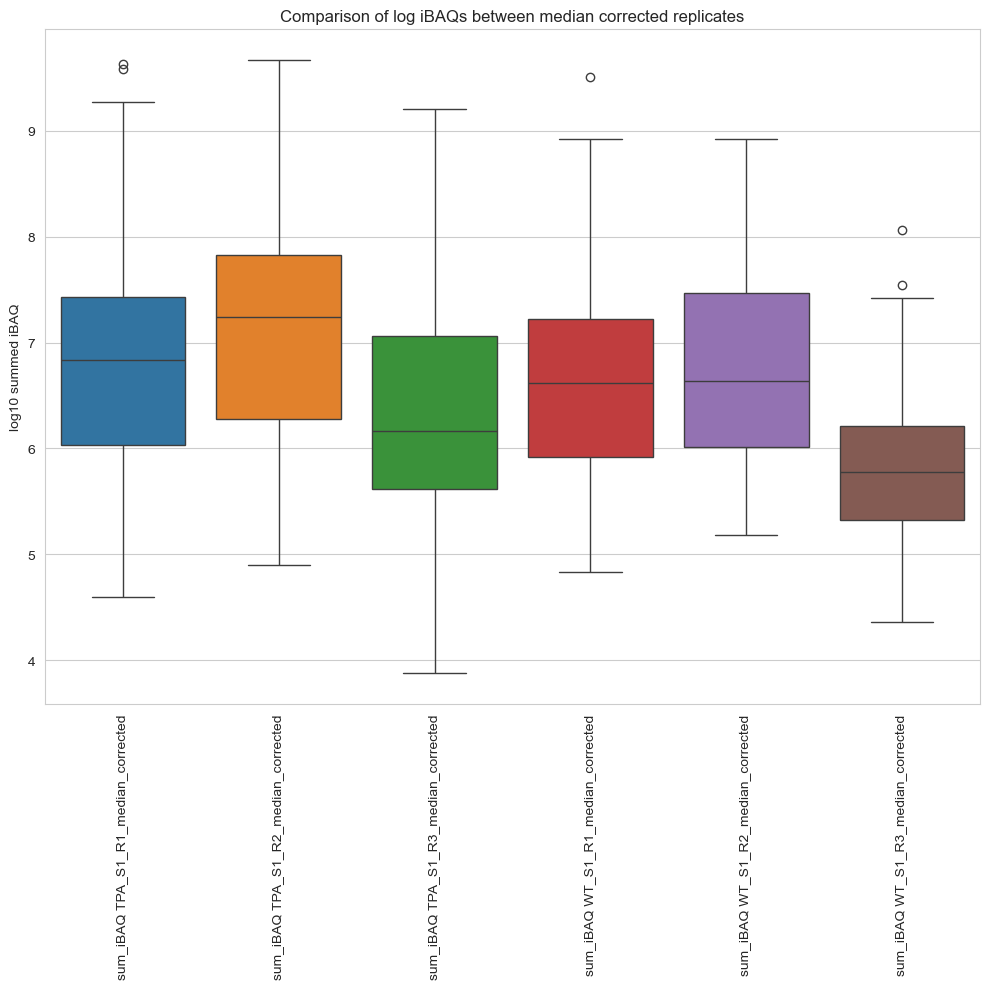

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 10))

sns.boxplot(
    data=np.log10(
        pg.filter(regex=f"sum_iBAQ .*_S\d+_R\d+_median_corrected")
    ).sort_index(axis=1),
    ax=ax,
)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_title("Comparison of log iBAQs between median corrected replicates")
ax.set_ylabel("log10 summed iBAQ")
plt.tight_layout()
plt.savefig("plots/01a_median_boxplot_reps.png")
plt.show()

In [10]:
s1_cols = pg.filter(regex="^sum_iBAQ .*_S1_R\d+_\w+_corrected").columns

display(pg.loc[:, s1_cols].isna().sum(0).sort_values().head())

sum_iBAQ TPA_S1_R3_median_corrected     7
sum_iBAQ TPA_S1_R1_median_corrected     8
sum_iBAQ TPA_S1_R2_median_corrected     9
sum_iBAQ WT_S1_R1_median_corrected     12
sum_iBAQ WT_S1_R2_median_corrected     32
dtype: int64

## VSN across replicates

In [11]:
pg, s1_cols = pp.vsn(
    pg,
    pg.filter(regex="^sum_iBAQ.*S1_R\d+_median_corrected$").columns.tolist(),
    return_cols=True,
)

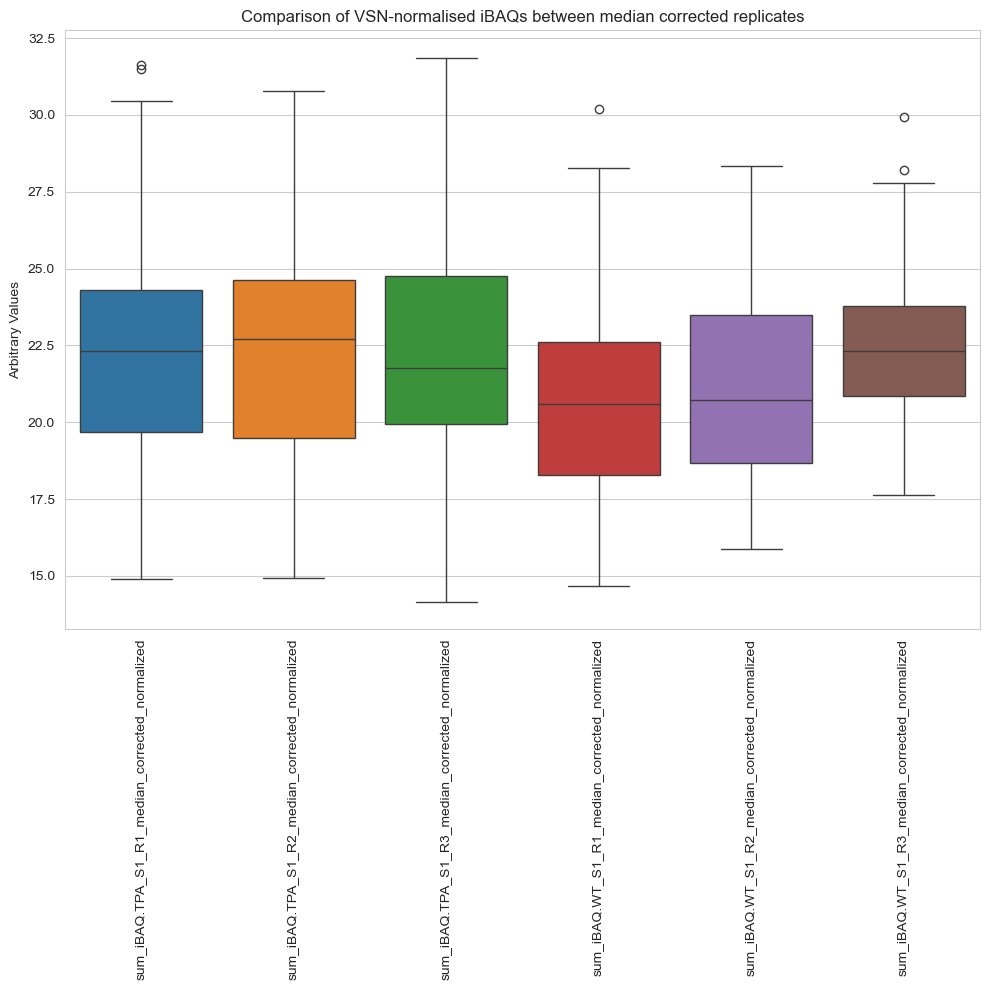

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 10))

sns.boxplot(data=pg.loc[:, s1_cols].sort_index(axis=1), ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_title("Comparison of VSN-normalised iBAQs between median corrected replicates")
ax.set_ylabel("Arbitrary Values")
plt.tight_layout()
plt.savefig("plots/01a_median_boxplot_reps_vsn.png")
plt.show()

## Treatment of missing values

Rows have to have at least 2 valid values in each comparison group (i.e. dpex8 3 reps vs TPA 3 reps and TPA 3 reps vs WT)

In [13]:
groups = [
    sorted(s1_cols)[:3],  # TPA R1-R3
]

pg_s1 = pp.filter_vv(pg, groups, n=2)

print("===MVs in S1===")
for g in groups:
    print(f"{pg_s1.loc[:,g].isna().sum().sum()} missing values in s1 columns")

80 rows before filter operation.
74 rows after filter operation.
===MVs in S1===
11 missing values in s1 columns


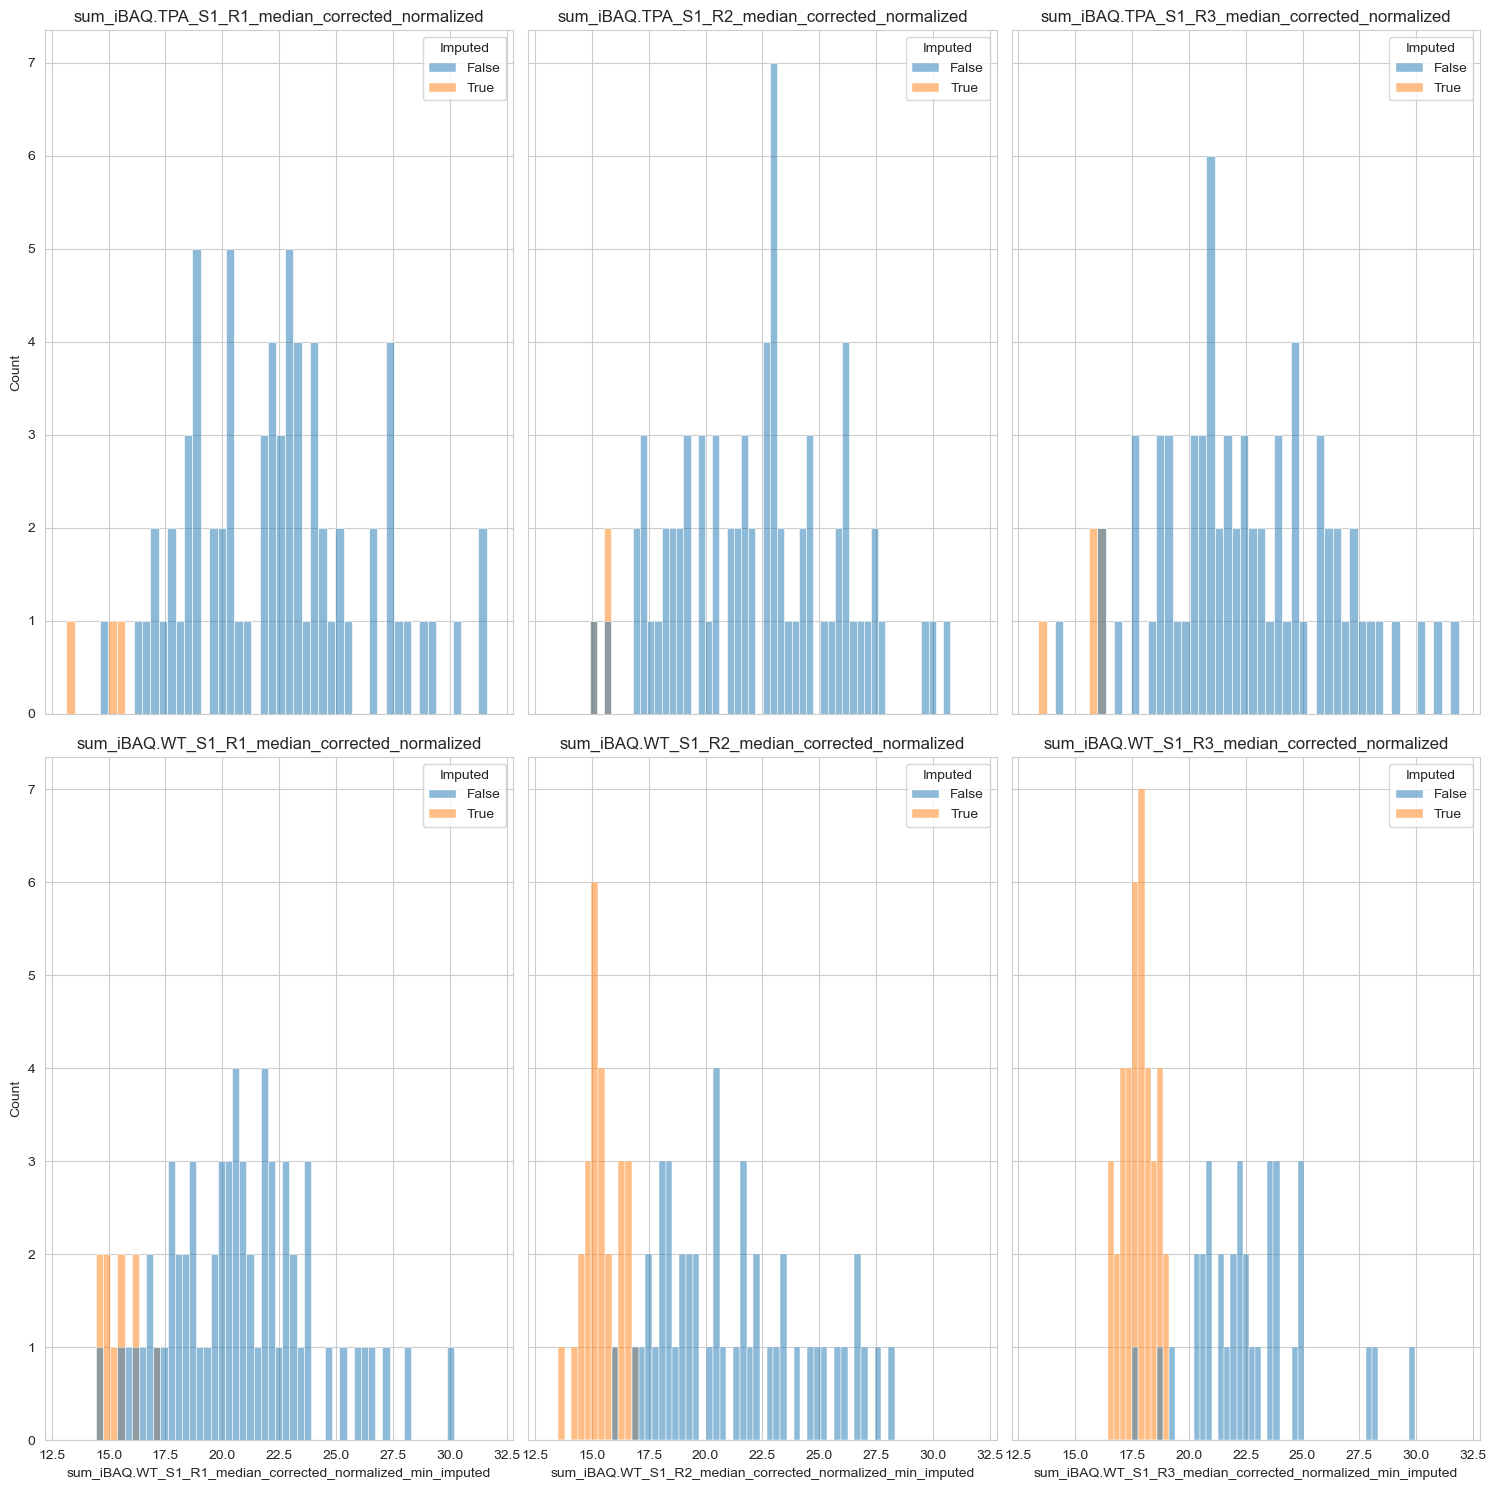

In [14]:
fig, ax = plt.subplots(
    math.ceil(len(s1_cols) / 3), 3, figsize=(15, 15), sharey="all", sharex="all"
)

# perform imputation separately on the dataframes
for idx, colname in enumerate(sorted(s1_cols)):
    imp_df = pp.imp_min_prob(df=pg_s1, cols_to_impute=[colname])
    imp_df["Imputed"] = False
    imp_df.loc[imp_df[colname].isnull(), "Imputed"] = True

    # histogram of imputed values
    sns.histplot(
        x=colname + "_min_imputed",
        data=imp_df,
        hue="Imputed",
        ax=ax[idx // 3, idx % 3],
        bins=50,
    )

    ax[idx // 3, idx % 3].set_title(colname)

    pg_s1[colname + "_imputed"] = imp_df[colname + "_min_imputed"]

plt.tight_layout()
plt.savefig("plots/01a_median_min_prob_imp.png")
plt.show()

In [15]:
# save data sets for next processing steps
with open("01a_preprocessing_s1.pkl", "wb") as of:
    pickle.dump(pg_s1, of)

## Quality check between reps


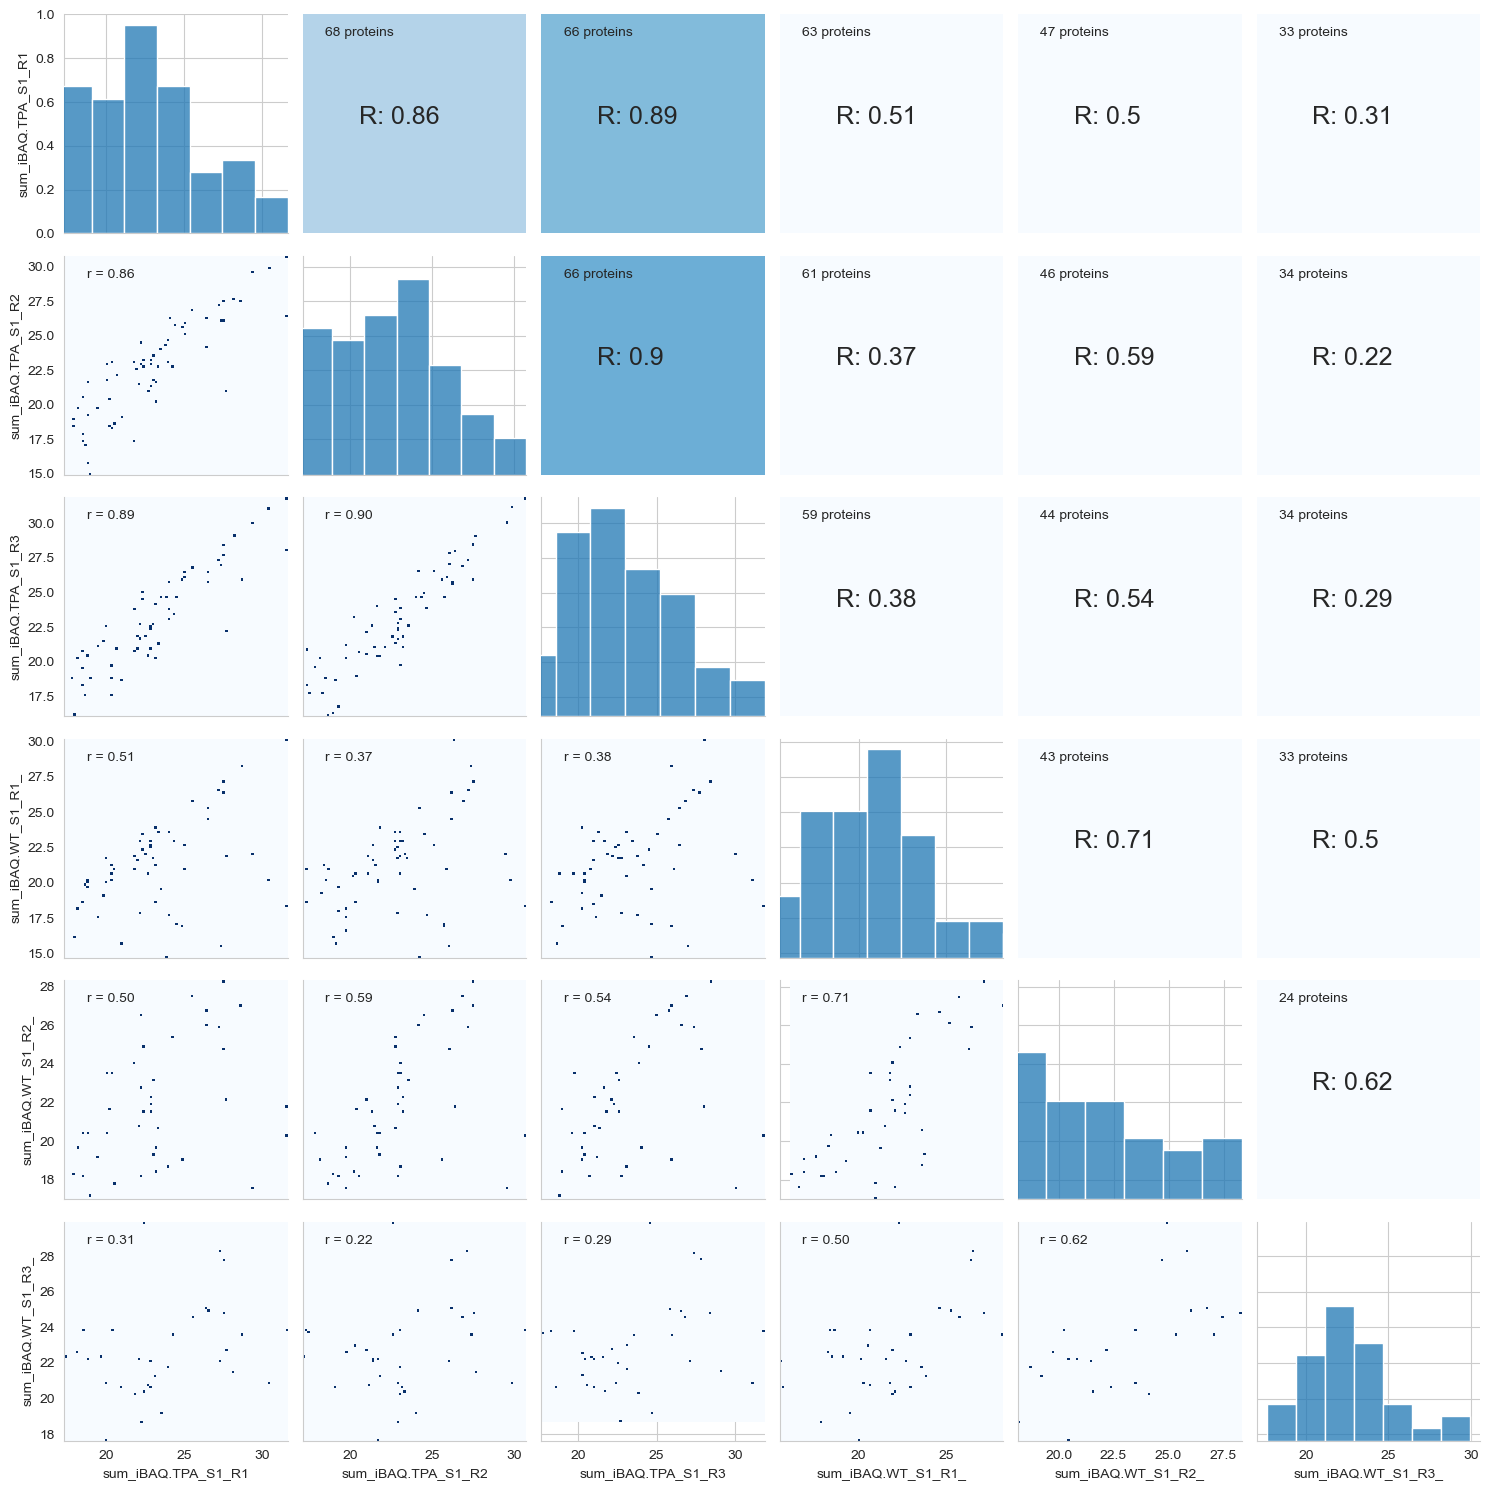

In [16]:
# TPA files
g = vis.correlogram(pg_s1, sorted(s1_cols)[:6], lower_triang="hist2d", ret_fig=True)

# see https://catherineh.github.io/programming/2016/05/24/seaborn-pairgrid-tips
# restrict label length
for c in g.fig.get_children():
    try:
        c.set_xlabel(c.get_xlabel()[:18])
        c.set_ylabel(c.get_ylabel()[:18])
    except:
        pass

plt.tight_layout()
plt.savefig("plots/01a_median_tpa_correlogram.png")